# Final Project

## Author: Cho Laam Yuen

## (1) describe in detail the substantive problem you are interested in working on for this assignment

For this project I was looking for a image classification problem that could be tied to something that I interacted with or used on a daily basis. One particular problem I am interested in is how tags are generated when videos or images are uploaded onto a digital platform. For example, I found that I could filter for different images of objects or people on the iPhone. Such that if I typed 'cat' into the search bar, I would get a selection of all the identified images of my cat from my photo album. This problem is related to object detection, but I believe that it is more broadly related to the similar problem of image classification. I perceive object detection to be a more straightforward problem, where there is more or less no overlap between categories. As such, I am more interested in whether neural networks can identify different themes from images that have objects that could belong to more than 1 category. 

For this project I am working to identify the content category (e.g. News, Food, Science, etc.) based on YouTube thumbnails. This problem of classifying thumbnails is relevant to the users' experience of watching videos on a platform such as YouTube. Thumbnails are almost always representative of the content of the video, for example a thumbnail of a person holding a huge burger most likely belongs to a Food channel. As such assigning accurate tags to video thumbnails can help users filter for videos of interest based on such tags and aid the algorithm in recommending other videos based on similar tags.

This is an interesting problem to me because there is both a diversity of thumbnails within categories as well as similarity of thumbnails between categories. More concretely, a thumbnail from a News channel could be of a news anchor seated professionally at a table or an image of an explosion from some newsworthy incident. From a object detection point of view the 2 images are completely unrelated as one depicts a person and the other depicts a scene. However, from a classification point of view, a neural network may be able to identify some similarity in the image beyond the objects involved. An example of similarity is an image of a person laughing which could be from a Comedy channel but could also belong to a Gaming channel. As an object detection problem these images would be classified as the same thing (i.e. a person). However, from a classification perspective perhaps there is something about the colors or positioning that could diffrentiate the 2 images. For these reasons, I believe that there is a lot of complexity in classifying these images into their respecctive categories and I am interested to explore how well neural networks will work for this specific problem. 


## (2) describe your data (including the features, target, and the general type of data you are working with)

I am working with image data downloaded from [Kaggle](https://www.kaggle.com/datasets/praneshmukhopadhyay/youtube-thumbnail-dataset) that has been classified into 10 categories. 

* Automobile
* Blog
* Comedy
* **Entertainment**
* Food
* **Informative**
* News
* Science
* **Tech**
* Video Games

However, since the dataset is quite small with only a total of 2303 images and the number of images within each category is quite uneven (min: 160; max: 300). I have decided to combine some categories together to create 3 large categories instead to better train my model for this problem. I elected to combine categories that are similar in content to one another and more distinct between categories, resulting in 3 large categories.

The 3 categories are **Entertainment**, **Informative**, and **Tech**. The **Entertainment** category encompasses Blog, Comedy, Entertainment, and Food. The **Informative** category includes News, Science, and Informative. Finally, the **Tech** category combines Automobile, Tech, and Video Games. This combination of categories also resulted in the number of images within categories to be more balanced (Entertainment: 813 | Informative: 716 | Tech: 774).





## (3) describe why you think Deep Learning systems would be a good methodological choice, and the specific architecture(s) you think appropriate to explore

I think that deep learning systems, would be appropriate to explore my chosen problem because image data is quite complex. Neural networks benefit from its ability to learn from the data in increasingly abstract ways, where a key strength is its capacity to deal with non-linear relationships which may be missed by other modeling approaches. For these reasons, deep learning is more suited for solving computer vision problems compared to shallow learning approaches. 

In particular, convolutional neural networks (CNNs) would be more appropriate compared to fully connected neural networks to explore my chosen problem. This is the case because fully connected neural networks suffers from a problem of inefficency since every node in every layer is fully connected to every node in the next layer. When it comes to images the resulting number of features get multiplied increasingly quickly, which substantially increases the runtime for models. On the other hand, CNNs are able to reduce the number of dimensions with the technique of running a filter through the image. This dimensionality reduction greatly improves the runtime of the models and also produces great results in regards to image data. 

I believe that implementing transfer learning would also help to solve my problem at hand. I plan on using 2 transfer learning models: ResNet50 and VGG16 that have been known to work well with image data. ResNet50 was created to deal with the vanishing gradient problem with very deep neural networks and VGG16 is a very popular model for image classification problems. It will be interesting to see which model would be better suited for classifying YouTube thumbnails. 

## Load Data and Packages

In [2]:
#connect to my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#change working directory
%cd /content/drive/My\ Drive/Adv\ ML/gr5074-final-project-ChoLaamY/
!pwd

/content/drive/My Drive/Adv ML/gr5074-final-project-ChoLaamY
/content/drive/My Drive/Adv ML/gr5074-final-project-ChoLaamY


In [4]:
#load my libraries
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

In [5]:
#code taken from example code for Covid_Image_Classification (HW2)
#extracting all filenames iteratively
base_path = 'thumbnails3'
categories = ['Entertainment', 'Informative', 'Tech',]

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])

number of images for each category: [813, 716, 774]


## Preprocess Data and Setup

In [6]:
#writing the preprocessor
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(224, 224)): 
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X


In [7]:
#check whether the preprocessor worked
#(Height, Width, Channels)
preprocessor('thumbnails3/Tech/_O_kWL-YhZE.jpg').shape

(224, 224, 3)

In [8]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [9]:
#check length of files matched number of images in my dataset
len(image_filepaths)
print(len(X) ) #same number of images in dataset
print(X.shape ) #dimensions should be 180, 320, 3 for all images
print(X.min() ) #min value of every image is 0
print(X.max() ) #max value of every image is 1


2303
(2303, 224, 224, 3)
0.0
1.0


In [10]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# 3 folders with the corresponding number of images in each folder

print('number of images for each category:', [len(f) for f in fnames])
Entertainment=list(repeat('Entertainment', 813))
Informative=list(repeat('Informative', 716))
Tech=list(repeat('Tech', 774))


#combine into single list of y labels
y_labels = Entertainment+Informative+Tech

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [813, 716, 774]
2303


,Entertainment,Informative,Tech
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
2298,0,0,1
2299,0,0,1
2300,0,0,1
2301,0,0,1


In [11]:
#train test split the dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 874920)

#check y_test set
y_test.sum()

Entertainment    163
Informative      143
Tech             155
dtype: int64

## Visualizing the Thumbnails

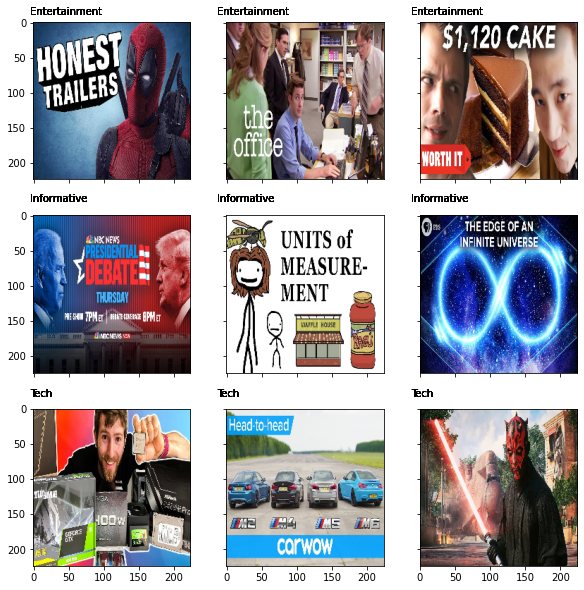

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

pic1 = preprocessor('thumbnails3/Entertainment/_qIRtFE6aIc.jpg')
pic2 = preprocessor('thumbnails3/Entertainment/8GxqvnQyaxs.jpg')
pic3 = preprocessor('thumbnails3/Entertainment/n4bucphC9r4.jpg')
pic4 = preprocessor('thumbnails3/Informative/UCA1A5GqCdQ.jpg')
pic5 = preprocessor('thumbnails3/Informative/el6No1wNKf0.jpg')
pic6 = preprocessor('thumbnails3/Informative/tJevBNQsKtU.jpg')
pic7 = preprocessor('thumbnails3/Tech/3dEfc9LL9bQ.jpg')
pic8 = preprocessor('thumbnails3/Tech/bCu0Z71QRF0.jpg')
pic9 = preprocessor('thumbnails3/Tech/DTBu4tigSDo.jpg')

#make a grid for the images
figure = plt.figure(figsize=(10, 10))
grid = ImageGrid(figure, 111,
                 nrows_ncols=(3, 3),
                 axes_pad=0.5,
                 )

for ax, pic in zip(grid, [pic1, pic2, pic3, pic4, pic5, pic6, pic7, pic8, pic9]):
  ax.imshow(pic)
  
#adjust the text size  
  plt.rc('font', size=10)

#create labels for images
  figure.text(0.13, 0.89, 'Entertainment', color="black")
  figure.text(0.39, 0.89, 'Entertainment', color="black")
  figure.text(0.66, 0.89, 'Entertainment', color="black")
  figure.text(0.13, 0.63, 'Informative', color="black")
  figure.text(0.39, 0.63, 'Informative', color='black')
  figure.text(0.66, 0.63, 'Informative', color='black')
  figure.text(0.13, 0.36, 'Tech', color='black')
  figure.text(0.39, 0.36, 'Tech', color='black')
  figure.text(0.66, 0.36, 'Tech', color='black')

  figure.show()

## Model Experimentation

## (4) show the code and outputs of 3-5 different experiments with variants of your proposed architecture(s)

#### Model 1 (CNN)

In [23]:
with tf.device('/device:GPU:0'):

  model1 = Sequential()
  model1.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
  model1.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model1.add(MaxPooling2D(pool_size=2))
  model1.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model1.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model1.add(MaxPooling2D(pool_size=2))
  model1.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model1.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model1.add(MaxPooling2D(pool_size=2))
  model1.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model1.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model1.add(MaxPooling2D(pool_size=2))

  model1.add(Dropout(0.1))
  model1.add(Flatten())
  model1.add(Dense(16, activation='relu')) # One fully-connected layer
  model1.add(Dropout(0.1))

  model1.add(Dense(3, activation='softmax'))

  model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model1.fit(X_train, y_train, 
                    epochs = 10, verbose=1, validation_data=(X_test,y_test))

Epoch 1/10
58/58 [==============================] - 113s 2s/step - loss: 1.0867 - accuracy: 0.3996 - val_loss: 1.0506 - val_accuracy: 0.4273
Epoch 2/10
58/58 [==============================] - 109s 2s/step - loss: 1.0302 - accuracy: 0.4756 - val_loss: 1.0000 - val_accuracy: 0.4816
Epoch 3/10
58/58 [==============================] - 109s 2s/step - loss: 0.9945 - accuracy: 0.5054 - val_loss: 1.0183 - val_accuracy: 0.4642
Epoch 4/10
58/58 [==============================] - 109s 2s/step - loss: 0.9469 - accuracy: 0.5467 - val_loss: 1.0030 - val_accuracy: 0.5141
Epoch 5/10
58/58 [==============================] - 108s 2s/step - loss: 0.9079 - accuracy: 0.5771 - val_loss: 1.0376 - val_accuracy: 0.5206
Epoch 6/10
58/58 [==============================] - 109s 2s/step - loss: 0.8723 - accuracy: 0.5950 - val_loss: 1.0006 - val_accuracy: 0.5293
Epoch 7/10
58/58 [==============================] - 109s 2s/step - loss: 0.8226 - accuracy: 0.6221 - val_loss: 0.9140 - val_accuracy: 0.5423
Epoch 8/10
58

## Image Augmentation

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#create augmentation function for training set
train_imagegen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=0.15,
                    height_shift_range=0.15,
                    horizontal_flip=True,
                    zoom_range=0.5,
                    validation_split=0.2) #set validation split

#create (no) augmentation function for test set
val_imagegen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


In [18]:
#augmentation on training set
train_data = train_imagegen.flow_from_directory(directory='thumbnails3',
                                                batch_size=128,
                                                shuffle=True,
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                subset = 'training')


Found 1844 images belonging to 3 classes.


In [19]:
#augmentation on test set
val_data = val_imagegen.flow_from_directory(directory='thumbnails3',
                                                batch_size=128,
                                                shuffle=False,
                                                target_size=(224, 224),
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                subset = 'validation')

Found 459 images belonging to 3 classes.


In [15]:
#code to plot images in a 1 x 5 grid from week 10 lecture notebook
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

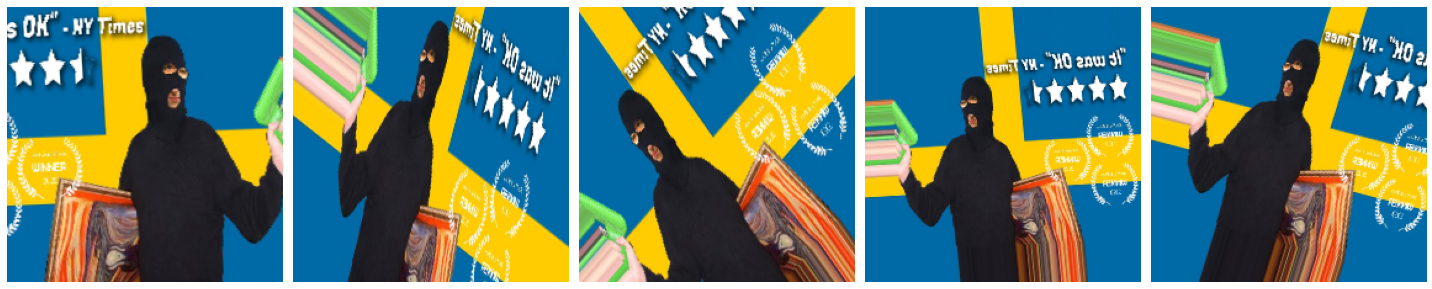

In [20]:
#plot the augmented images to check
augmented_images = [train_data[0][0][0] for i in range(5)]
plotImages(augmented_images)

#### Model 2 (CNN) with image augmentation

In [25]:
with tf.device('/device:GPU:0'):

  model2 = Sequential()
  model2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
  model2.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model2.add(MaxPooling2D(pool_size=2))
  model2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model2.add(MaxPooling2D(pool_size=2))
  model2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model2.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model2.add(MaxPooling2D(pool_size=2))
  model2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
  model2.add(Conv2D(filters=32, kernel_size=1, padding='same', activation='relu'))
  model2.add(MaxPooling2D(pool_size=2))
  model2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
  model2.add(MaxPooling2D(pool_size=2))

  model2.add(Dropout(0.1))
  model2.add(Flatten())
  model2.add(Dense(16, activation='relu')) # One fully-connected layer
  model2.add(Dropout(0.1))

  model2.add(Dense(3, activation='softmax'))

  model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model2.fit(train_data, 
           epochs=10, verbose=1, validation_data=val_data,
           steps_per_epoch=1844 // 128,
           validation_steps=459 // 128)

Epoch 1/10
14/14 [==============================] - 136s 9s/step - loss: 1.0996 - accuracy: 0.3456 - val_loss: 1.1232 - val_accuracy: 0.2057
Epoch 2/10
14/14 [==============================] - 131s 10s/step - loss: 1.0946 - accuracy: 0.3741 - val_loss: 1.0840 - val_accuracy: 0.4688
Epoch 3/10
14/14 [==============================] - 136s 10s/step - loss: 1.0815 - accuracy: 0.4068 - val_loss: 1.1973 - val_accuracy: 0.2266
Epoch 4/10
14/14 [==============================] - 137s 10s/step - loss: 1.0833 - accuracy: 0.4365 - val_loss: 1.0498 - val_accuracy: 0.5130
Epoch 5/10
14/14 [==============================] - 134s 9s/step - loss: 1.0324 - accuracy: 0.4878 - val_loss: 1.0685 - val_accuracy: 0.3984
Epoch 6/10
14/14 [==============================] - 134s 9s/step - loss: 1.0394 - accuracy: 0.4709 - val_loss: 0.9965 - val_accuracy: 0.5260
Epoch 7/10
14/14 [==============================] - 134s 9s/step - loss: 1.0363 - accuracy: 0.4854 - val_loss: 1.0038 - val_accuracy: 0.4714
Epoch 8/10

#### Model 3 (ResNet50) with image augmentation

In [27]:
from tensorflow.keras.applications import ResNet50
with tf.device('/device:GPU:0'):
  
  base_model_res = ResNet50(input_shape=(224, 224, 3), 
                          include_top=False, 
                          weights='imagenet')
  
#freeze the weights
  base_model_res.trainable = False

#flatten, add 3 dense layers, and 2 droupout
flat = Flatten()(base_model_res.layers[-1].output)
layer1 = Dense(16, activation='relu')(flat)
drop = Dropout(0.1)(layer1)
output = Dense(3, activation='softmax')(drop)

model3 = Model(inputs=base_model_res.inputs, outputs=output)

#compile model
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model3.fit(train_data, epochs=7, verbose=1, validation_data=val_data,
           steps_per_epoch=1844 // 128,
           validation_steps=459 // 128)


Epoch 1/7
14/14 [==============================] - 266s 19s/step - loss: 4.7093 - accuracy: 0.3549 - val_loss: 1.0984 - val_accuracy: 0.4193
Epoch 2/7
14/14 [==============================] - 264s 19s/step - loss: 1.0980 - accuracy: 0.3578 - val_loss: 1.0982 - val_accuracy: 0.4219
Epoch 3/7
14/14 [==============================] - 281s 20s/step - loss: 1.0983 - accuracy: 0.3572 - val_loss: 1.0981 - val_accuracy: 0.4219
Epoch 4/7
14/14 [==============================] - 266s 19s/step - loss: 1.0983 - accuracy: 0.3520 - val_loss: 1.0982 - val_accuracy: 0.4219
Epoch 5/7
14/14 [==============================] - 262s 19s/step - loss: 1.0981 - accuracy: 0.3555 - val_loss: 1.0983 - val_accuracy: 0.4219
Epoch 6/7
14/14 [==============================] - 263s 19s/step - loss: 1.0981 - accuracy: 0.3520 - val_loss: 1.0982 - val_accuracy: 0.4219
Epoch 7/7
14/14 [==============================] - 261s 19s/step - loss: 1.0981 - accuracy: 0.3497 - val_loss: 1.0982 - val_accuracy: 0.4219


#### Model 4 (ResNet50) **without** image augmentation

In [28]:
from tensorflow.keras.applications import ResNet50
with tf.device('/device:GPU:0'):
  
  base_model_resnet = ResNet50(input_shape=(224, 224, 3), 
                          include_top=False, 
                          weights='imagenet')
  
#freeze the weights
  base_model_resnet.trainable = False

#flatten, add 3 dense layers, and 2 droupout
flat = Flatten()(base_model_resnet.layers[-1].output)
layer1 = Dense(16, activation='relu')(flat)
drop = Dropout(0.1)(layer1)
output = Dense(3, activation='softmax')(drop)

model4 = Model(inputs=base_model_resnet.inputs, outputs=output)

#compile model
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model4.fit(X_train, y_train, 
           epochs=7, verbose=1, validation_data=(X_test, y_test))

Epoch 1/7
58/58 [==============================] - 262s 4s/step - loss: 1.1942 - accuracy: 0.3512 - val_loss: 1.0982 - val_accuracy: 0.3514
Epoch 2/7
58/58 [==============================] - 257s 4s/step - loss: 1.0980 - accuracy: 0.3529 - val_loss: 1.0979 - val_accuracy: 0.3514
Epoch 3/7
58/58 [==============================] - 257s 4s/step - loss: 1.0979 - accuracy: 0.3529 - val_loss: 1.0976 - val_accuracy: 0.3514
Epoch 4/7
58/58 [==============================] - 257s 4s/step - loss: 1.0976 - accuracy: 0.3529 - val_loss: 1.0975 - val_accuracy: 0.3514
Epoch 5/7
58/58 [==============================] - 255s 4s/step - loss: 1.0976 - accuracy: 0.3529 - val_loss: 1.0974 - val_accuracy: 0.3514
Epoch 6/7
58/58 [==============================] - 256s 4s/step - loss: 1.0975 - accuracy: 0.3529 - val_loss: 1.0974 - val_accuracy: 0.3514
Epoch 7/7
58/58 [==============================] - 256s 4s/step - loss: 1.0974 - accuracy: 0.3529 - val_loss: 1.0973 - val_accuracy: 0.3536


#### Model 5 (VGG16) **without** image augmentation

In [31]:
from tensorflow.python.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint
with tf.device('/device:GPU:0'):

  base_model_VGG = VGG16(input_shape=(224, 224, 3),
                   include_top=False,
                   weights='imagenet')
#freeze weights
base_model_VGG.trainable=False

#flatten, add dense layer, dropout, and another dense layer 
flat = Flatten()(base_model_VGG.layers[-1].output)
layer1 = Dense(16, activation='relu')(flat)
drop = Dropout(0.1)(layer1)
output = Dense(3, activation='softmax')(drop)

model5 = Model(inputs=base_model_VGG.inputs, outputs=output)

#compile model
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model5.fit(X_train, y_train, 
           epochs=7, verbose=1, validation_data=(X_test, y_test))

Epoch 1/7
58/58 [==============================] - 864s 15s/step - loss: 0.9661 - accuracy: 0.5347 - val_loss: 0.8685 - val_accuracy: 0.6161
Epoch 2/7
58/58 [==============================] - 866s 15s/step - loss: 0.6741 - accuracy: 0.7020 - val_loss: 0.7061 - val_accuracy: 0.6941
Epoch 3/7
58/58 [==============================] - 868s 15s/step - loss: 0.4853 - accuracy: 0.8024 - val_loss: 0.7002 - val_accuracy: 0.6898
Epoch 4/7
58/58 [==============================] - 868s 15s/step - loss: 0.3479 - accuracy: 0.8702 - val_loss: 0.7020 - val_accuracy: 0.7115
Epoch 5/7
58/58 [==============================] - 871s 15s/step - loss: 0.2577 - accuracy: 0.9142 - val_loss: 0.7134 - val_accuracy: 0.7072
Epoch 6/7
58/58 [==============================] - 871s 15s/step - loss: 0.1961 - accuracy: 0.9392 - val_loss: 0.7853 - val_accuracy: 0.7180
Epoch 7/7
58/58 [==============================] - 868s 15s/step - loss: 0.1616 - accuracy: 0.9468 - val_loss: 0.7966 - val_accuracy: 0.7072


#### *Additional Model* (VGG16) with image augmentation

In [18]:
#NOT include
from tensorflow.python.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.callbacks import ModelCheckpoint
with tf.device('/device:GPU:0'):

  base_model = VGG16(input_shape=(224, 224, 3),
                   include_top=False,
                   weights='imagenet')
#freeze weights
base_model.trainable=False

#flatten, add dense layer, dropout, and another dense layer 
flat = Flatten()(base_model.layers[-1].output)
layer1 = Dense(16, activation='relu')(flat)
drop = Dropout(0.1)(layer1)
output = Dense(3, activation='softmax')(drop)

model4 = Model(inputs=base_model.inputs, outputs=output)

#compile model
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model4.fit(train_data, epochs=7, verbose=1, validation_data=val_data)


Epoch 1/7
15/15 [==============================] - 1031s 69s/step - loss: 1.5717 - accuracy: 0.3698 - val_loss: 1.0909 - val_accuracy: 0.4096
Epoch 2/7
15/15 [==============================] - 1083s 73s/step - loss: 1.0806 - accuracy: 0.4268 - val_loss: 1.0699 - val_accuracy: 0.4597
Epoch 3/7
15/15 [==============================] - 1023s 69s/step - loss: 1.0687 - accuracy: 0.4268 - val_loss: 1.0587 - val_accuracy: 0.4793
Epoch 4/7
15/15 [==============================] - 1026s 69s/step - loss: 1.0663 - accuracy: 0.4300 - val_loss: 1.0641 - val_accuracy: 0.4597
Epoch 5/7
15/15 [==============================] - 1079s 73s/step - loss: 1.0686 - accuracy: 0.4138 - val_loss: 1.0591 - val_accuracy: 0.4793
Epoch 6/7
15/15 [==============================] - 1022s 69s/step - loss: 1.0603 - accuracy: 0.4246 - val_loss: 1.0778 - val_accuracy: 0.4074
Epoch 7/7
15/15 [==============================] - 1024s 69s/step - loss: 1.0548 - accuracy: 0.4371 - val_loss: 1.0598 - val_accuracy: 0.4444


## (5) select the model that best fits the problem you are trying to solve and discuss why it fulfills this purpose

The best model is Model 5 with a validation accuracy score of 0.71, which implements transfer learning with the VGG16 model, with an addditional fully connected layer and dropout layer added at the end.  

In the following section, I will talk about the various modelling approaches I experimented with and explain why Model 5 is the best model. The first model (Model 1) I tried was a convolutional neural network (CNN) with 8 convolutional layers with a max pooling layer between every 2 convolutional layers with a dropout layer at the end. Next the model was flattened into a fully connected network with an additional fully connected layer and dropout layer, finally it was optimized using 'rmsprop' and trained with 10 epochs. Model 1 had a validation accuracy of 0.56. 

Since the dataset that I have is not very big (a total of 2303 images), I decided to experiment with image augmentation to see whether introducing additional variation to my exsiting dataset would improve the model's performance. I introduced 4 different methods of augmentation, rotating (up to 45 degrees), shifting the range, horizontally flip, and zooming (up to 50%) the image. Model 2 is a copy of the modeling architechture of Model 1 with 2 additional convolutional layers and a max pooling layer, as well as using the augmented dataset rather than simply the preprocessed dataset. The resulting validation accuracy score is 0.55, which is only slightly worse than Model 1 (0.56). Since there was not a lot of improvement, I proceeded to try out transfer learning models with the augmented dataset. 

Model 3 is a transfer learning network with ResNet50, I freezed the weights of the network, added a fully connected layer, a dropout layer, optimized with 'adam' at the end and trained the network with 7 epochs. The validation accuracy score is 0.42, indicating that the model is performing even worse than Model 1 (0.56) which was just a simple convolutional neural network without image augmentation. I also ran a transfer learning network with VGG16 using the augmented dataset (*included at the end as an additional model*) with a validation accuracy score of 0.44, which was not much different from the transfer learning network with ResNet50. 

Since it appeared that image augmentation did not really improve the models I have been experimenting with. I decided to rerun the transfer learning models on the originally preprocessed dataset instead. I reran the same transfer learning with ResNet50 network on the preprocessed dataset which resulted in a validation accuracy score of 0.35. I did the same for the transfer learning with VGG16 which resulted in the highest overall validation score of 0.71. 

My conclusion on using image augmentation is somewhat uncertain, it appears that image augmentation improved the transfer learning network with ResNet50 (augmented: 0.42; unagmented: 0.35). However, the validation accuracy score was much worse for transfer learning network with VGG16 (augmented: 0.44; unagmented: 0.71) and only slightly worse for my own CNN (augmented: 0.55; unagmented: 0.56). One hypothesis could be that transfer learning with ResNet50 was not the most appropriate for my dataset. Since the network was intended to tackle the problem of vanishing gradients with very deep neural networks, perhaps the YouTube thumbnails dataset did not require such a deep network and as a result did not benefit from the ResNet50 architechture. On the other hand, VGG16 was built for image classification and has been proven to perform very well on a diverse set of image classification problems. Therefore, this may be one reason why the transfer learning model with VGG16 performed so well on this problem.

I chose Model 5 (transfer learning model with VGG16) as my best model. In addition to having the best validation accuracy score (0.71), far outstriping all the other models I have experimented with, I also believe that this model is more likely to predict well on a new dataset due to its high validation accuracy. 

Overall, when experimenting with these various models I have found that categorizing YouTube thumbnails is not a very easy problem to tackle. I have used ResNet50 and VGG16 on previous image classification problems and they have always performed very well (above 0.6 validation accuracy score). This may indicate that thumbnails are quite complex images with a lot of diversity within categories and much similarity between categories as well. However, this is just an inference based on my limited experience with transfer learning models and neural networks in general. The real answer to why these models did not perform as well may lie in the hyperparameters used which could be subject to more in-depth exploration. 





